# CSC/XMM validation catalogs, XMM/CSC hostless catalog

In [190]:
import sys
sys.path.append('../')

In [191]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np

import matplotlib.pyplot as plt
# plt.style.use('seaborn')

import seaborn as sns

from scripts.utils import set_mpl, data_path
from scripts.cross_match_scripts import cross_match_data_frames,  add_separation_columns
set_mpl()

%matplotlib inline
from astropy.table import Table

matplotlib settings set


In [192]:
def csc_error_converter(df: pd.DataFrame,
                        r0_colname='err_ellipse_r0',
                        r1_colname='err_ellipse_r1') -> pd.DataFrame:
    """
    The function converts default radii `r0_colname`
    and `r1_colname` to the one-sigma error.

    Args:
        df (pd.DataFrame): DataFrame with `r0_colname` and
        `r1_colname` columns.
        
        r0_colname (str): major radius of the 95% confidence
        level position error ellipse.
        Defaults to 'err_ellipse_r0'.
        
        r1_colname (str): minor radius of the 95% confidence
        level position error ellipse.
        Defaults to 'err_ellipse_r1'.

    Returns:
        pd.DataFrame: one-sigma error in arcseconds.
    """

    # Conversion coefficient
    csc_sigma_coeff = np.sqrt(-(1 / (2 * np.log(1 - .95))))

    err_r1 = df[r0_colname]
    err_r2 = df[r1_colname]
    # Effective error
    csc_err_eff = np.sqrt(err_r1 ** 2 + err_r2 ** 2)

    csc_1sigma = csc_sigma_coeff * csc_err_eff

    return csc_1sigma


def vot2pd_csc(csc_cat_path: str,
               colnames: list,
               save_coords: bool = False, 
               radec_fits_name: str = 'cscresults_name_radec') -> pd.DataFrame:
    """
    The function converts the votable file to pandas DataFrame.

    Optionally saves the separate file with the coordinates and names of
    the CSC sources to the FITS file.

    Args:
        csc_cat_path (str): the path to the votable file.
        colnames (list): column names of the votable file.
        save_coords (bool): if True, saves the separate file with the coordinates
        and names of the CSC sources to the FITS file.
        radec_fits_name (str): name of the FITS file with
        the coordinates and names of the CSC sources to be saved.

    Returns:
        pd.DataFrame: converted catalogue.
    """
    
    vot_table = Table.read(csc_cat_path, format='votable')
    
    df = vot_table.to_pandas()
    df.columns = colnames

    df = df.assign(flux_csc_05_2 = lambda x: x.flux_aper_s + x.flux_aper_m)

    one_sigma_errors = csc_error_converter(df)

    df = df.assign(radec_err_csc = one_sigma_errors)

    df['r_98_csc'] = tsource_r(sigma=df['radec_err_csc'], t_thresh=.02)

    if save_coords:

        df_init_coords = df[['name', 'ra', 'dec']]
        Table.from_pandas(df_init_coords).write(f'data/{radec_fits_name}.fits', format='fits')

    return df


def tsource_r(sigma: float, t_thresh: float) -> float:
    """
    Calculates the radius of circle which contains the probability `t_thresh`
    NOT to find a counterpart for a source with localization error `sigma`.

    Args:
        sigma (float): localization error in arcsec.
        t_thresh (float): probability to NOT find a counterpart.

    Returns:
        float: radius of circle in arcsec.
    """
    
    rsearch = sigma * np.sqrt(-2 * np.log(t_thresh))
    
    return rsearch


def fsource_r(rho: float, f_thresh: float) -> float:
    """
    The function calculates the radius which corresponds to the probability `f_thresh`
    to FIND one or more false sources. 

    Args:
        rho (float): the density of the false sources (in arcmin^{-2}).
        f_thresh (float): probability to FIND one or more false sources.

    Returns:
        float: radius (in arcsec).
    """

    rho = rho / 3600 # arcmin^{-2} -> arcsec^{-2}
    pf_r = np.sqrt(-1 / (rho * np.pi) * np.log(1 - f_thresh))
    
    return pf_r


def poserr2sigma_coeff(conf_level: float) -> float:
    """
    Calculates convertion coefficient to go from
    positional error to sigma given confidence level.

    For details see:
    https://www.notion.so/Theory-ca6e7795b40c43b4ba6d96bc59727efa#b4d9fc11ff8243a3834e9eeba08c2273
    """
    coeff = (-2 * np.log(1 - conf_level)) ** -0.5
    
    return coeff


def pos_r(sigma: float, conf_level: float) -> float:
    """
    Calculates the radius of circle which contains the probability `conf_level`
    of finding (opposite to tsource_r()) a counterpart for a source with
    localization error `sigma`.

    For details see:
    https://www.notion.so/Theory-ca6e7795b40c43b4ba6d96bc59727efa#0ba88df64d2d4d9583f93d63dbe1b927

    Args:
        sigma (float): localization error in arcsec.
        conf_level (float): probability of finding a counterpart.

    Returns:
        float: radius of circle in arcsec.
    """
    
    r_pos = sigma * np.sqrt(-2 * np.log(1 - conf_level))

    return r_pos


def only_reliable_xmm(df: pd.DataFrame) -> pd.DataFrame:
    """
    Filters out unreliable XMM sources.
    """
    reliable_df = df[
                    ((df['SC_SUM_FLAG'] == 0) |
                    (df['SC_SUM_FLAG'] == 1)) &
                    (df['SC_DET_ML'] > 10) &
                    ~(df['SC_VAR_FLAG'] == True) &
                    (df['SC_EXTENT'] == 0) &
                    (df['CONFUSED'] == False)
                    ]

    return reliable_df






srg_names = {
            'id_src_name': 'srcname_fin',  # Индексы рентгеновских источников
            'x_ra_name': 'RA_fin',  # Координаты рентгеновских источников
            'x_dec_name': 'DEC_fin',
            'dl_name': 'DET_LIKE_0',  # Detection Likelihood
            'x_flux_name': 'flux_05-20',
            'ext_name': 'EXT_LIKE',  # Протяженность рентгеновских источников
            'ls_ra_name': 'ra',  # Координаты источников DESI
            'ls_dec_name': 'dec',
            'r_98_name': 'pos_r98',  # Позиционная ошибка
            'sigma_2d_name': 'pos_sigma_2d'
            }


***

In [193]:
# Каталог ERO (9500)
ero_df = pd.read_pickle(data_path+'ERO_lhpv_03_23_sd01_a15_g14.pkl') #TODO note the ero catalog that you are using!
#ero_df = pd.read_pickle(data_path+'ERO_lhpv_03_23_sd01_a15_g14_orig.pkl') 
ero_df.sample(5)

,srcname_fin,RA_fin,DEC_fin,GLON,GLAT,pos_r98,DET_LIKE_0,ML_FLUX_0,ML_FLUX_ERR_0,ML_CTS_0,ML_CTS_ERR_0,ML_EXP_1,EXT,EXT_LIKE,EXT_ERR,ID_SRC,ID_CLUSTER,RA,DEC,RADEC_ERR,DIST_NN,SRCDENS,TSTART,TSTOP,EXT_LOWERR,EXT_UPERR,ML_RATE_0,ML_RATE_ERR_0,ML_BKG_0,RA_corr,DEC_corr,g_id,g_d2d,g_nsrc,g_s,g_gmag,g_maxLx,g_b,s_id,s_z,s_otype,s_d2d,s_nsrc,flag_xray,flag_radio,flag_agn_wise,w1,w2,w3,w1snr,w2snr,w3snr,w_nsrc,sdss_nsrc,sdss_p,sdss_id,sdss_sp,sdss_d2d,hpidx,RADEC_ERR_fin,pos_sigma_2d,pos_r68,pos_r95,ELON,ELAT,flux_05-20,NH
994,SRGe J103942.9+593720,159.928589,59.622150,148.513517,50.455915,3.877105,166.148376,2.604642e-14,2.759517e-15,121.550095,12.877760,4263.387207,0.0,0.0,0.0,949,772,159.930598,59.620861,1.509257,74.649826,0.000007,6.268413e+08,6.270701e+08,0.0,0.0,0.028510,0.003021,17.699150,159.928589,59.622150,-1,-1.0,0,-1,NaN,-1.0,-1,SDSS J103943.07+593720.3,0.346876,QSO,5.811984,1,0,0,2,15.296000,14.894,12.153,29.5,18.4,1.2,2,2,0,1237655369282683259,0,5.849259,56607338818,1.509257,1.386091,2.092433,3.392801,133.393614,46.260054,2.004374e-14,1.026257e+20
6904,SRGe J103528.6+565918,158.869220,56.988260,152.341346,51.664768,8.864356,11.579835,4.839887e-15,1.458431e-15,22.880846,6.894816,4319.011719,0.0,0.0,0.0,6788,5685,158.871229,56.986970,3.873723,150.106964,0.000007,6.268413e+08,6.270701e+08,0.0,0.0,0.005298,0.001596,20.448677,158.869220,56.988260,-1,-1.0,0,-1,NaN,-1.0,-1,NaN,NaN,NaN,-1.000000,0,0,0,0,17.177999,16.938,12.862,9.0,1.4,-1.1,1,0,-1,0,0,NaN,66565015616,3.873723,3.169067,4.783999,7.757074,134.687255,43.728194,3.724481e-15,5.309038e+19
6513,SRGe J104858.2+565754,162.242564,56.964926,150.483265,53.111883,8.582221,10.493905,5.174756e-15,1.556244e-15,23.336567,7.018183,4119.975098,0.0,0.0,0.0,6089,5035,162.244573,56.963636,3.744303,67.647842,0.000005,6.268413e+08,6.270701e+08,0.0,0.0,0.005664,0.001703,99.802353,162.242564,56.964926,-1,-1.0,0,-1,NaN,-1.0,-1,NaN,NaN,NaN,-1.000000,0,0,0,-1,NaN,NaN,NaN,NaN,NaN,NaN,0,0,-1,0,0,NaN,66656271180,3.744303,3.068202,4.631734,7.510182,136.889587,44.670030,3.982176e-15,6.773975e+19
1369,SRGe J102937.1+561229,157.404398,56.207922,154.115634,51.458605,4.722142,104.934715,2.052648e-14,2.493193e-15,100.152222,12.164718,4457.523438,0.0,0.0,0.0,1438,1142,157.406406,56.206633,1.932189,147.751831,0.000007,6.268413e+08,6.270701e+08,0.0,0.0,0.022468,0.002729,20.296614,157.404398,56.207922,-1,-1.0,0,-1,NaN,-1.0,-1,NaN,NaN,NaN,-1.000000,0,0,0,0,16.202000,16.079,12.695,19.7,7.5,-0.8,3,3,0,1237655107297674168,0,4.394800,69655494914,1.932189,1.688198,2.548490,4.132281,134.275480,42.647005,1.579593e-14,6.373423e+19
8919,SRGe J104921.8+573538,162.340967,57.594014,149.641542,52.736273,8.332431,7.028266,3.203751e-15,1.183265e-15,15.112206,5.581501,4309.398438,0.0,0.0,0.0,8865,7711,162.342975,57.592725,3.629536,83.837296,0.000007,6.268413e+08,6.270701e+08,0.0,0.0,0.003507,0.001295,25.462551,162.340967,57.594014,-1,-1.0,0,-1,NaN,-1.0,-1,NaN,NaN,NaN,-1.000000,0,0,0,-1,NaN,NaN,NaN,NaN,NaN,NaN,0,0,-1,0,0,NaN,64208759501,3.629536,2.978901,4.496925,7.291595,136.477115,45.229824,2.465411e-15,6.808708e+19


In [194]:
# desi_lh.gz_pkl number of sources and area
false_dens_arcmin = 2418574 / (41.729 * 3600)
print(false_dens_arcmin)
false_dens_arcsec = false_dens_arcmin / 3600

print(f'{ false_dens_arcsec:.3f}')

FALSE_PROB = .03

r_false = fsource_r(false_dens_arcmin, FALSE_PROB)

print(f'Радиус для {FALSE_PROB:.0%} вероятности найти ложный: {r_false:.2f}"')

desi = pd.read_pickle(data_path+'desi_lh.gz_pkl', compression='gzip')
desi.sample(5)

16.099741453452303
0.004
Радиус для 3% вероятности найти ложный: 1.47"


,release,objid,brickid,ra,dec,flux_g,flux_r,flux_z,flux_w1,flux_w2,flux_w3,flux_w4,flux_ivar_g,flux_ivar_r,flux_ivar_z,flux_ivar_w1,flux_ivar_w2,flux_ivar_w3,flux_ivar_w4,dered_mag_g,dered_mag_r,dered_mag_z,dered_mag_w1,dered_mag_w2,dered_mag_w3,dered_mag_w4,snr_g,snr_r,snr_z,snr_w1,snr_w2,snr_w3,snr_w4,type,parallax,parallax_ivar,pmra,pmra_ivar,pmdec,pmdec_ivar,ref_cat,ref_id,mjd_max,mjd_min,iso_max,iso_min,desi_id
1520809,9011,902,608388,164.585413,56.912992,0.065295,0.145698,1.232351,6.633601,8.061108,-43.115017,446.77704,561.83594,259.85672,98.931465,4.778480,1.174857,0.001626,0.000020,25.428700,24.568392,22.260313,20.443674,20.232815,NaN,15.874677,1.547688,2.348666,12.257496,14.500876,8.737502,-1.738333,2.003327,PSF,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,58194.410133,57784.446158,2018-03-17 09:50:35.462,2017-01-31 10:42:28.080,9011_608388_902
140862,9011,1730,618899,164.560739,60.569417,0.302720,0.555120,0.489580,-0.908877,-1.724696,-3.004221,-353.68344,939.91640,185.95290,101.235880,3.845240,1.124316,0.001649,0.000020,23.772934,23.122555,23.266224,NaN,NaN,NaN,NaN,9.280807,7.569865,4.925961,-1.782243,-1.828760,-0.122005,-1.567817,PSF,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,58246.182176,57414.434919,2018-05-08 04:22:19.980,2016-01-27 10:26:17.000,9011_618899_1730
309804,9011,1178,621005,159.991502,61.195693,0.198010,0.705323,5.236796,4.583375,4.883927,-21.933548,605.96350,664.73930,220.74135,134.998700,4.539883,1.093609,0.001062,0.000014,24.235077,22.863400,20.693592,20.845709,20.777262,NaN,15.543818,5.105198,10.479237,60.845780,9.765798,5.107403,-0.714611,2.241386,PSF,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,58245.176656,57414.410104,2018-05-07 04:14:23.061,2016-01-27 09:50:33.000,9011_621005_1178
1762689,9011,1612,603557,161.281022,55.494720,0.380080,1.402722,3.651813,13.476777,10.004935,71.493420,53.85319,614.42035,175.00833,75.225280,4.006485,1.062898,0.001448,0.000018,23.521168,22.112938,21.082747,19.674366,19.998440,17.864117,18.171888,9.421223,18.556713,31.673086,26.975395,10.314781,2.720877,0.228041,REX,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,57901.178773,57497.233588,2017-05-28 04:17:26.000,2016-04-19 05:36:22.000,9011_603557_1612
823585,9011,1817,612264,165.575120,58.339329,0.218503,0.239021,0.588470,1.692338,-0.140498,-10.209612,1666.19960,792.07800,251.22798,81.632470,4.937711,1.214098,0.000991,0.000013,24.127434,24.037794,23.066677,21.927412,NaN,NaN,14.445615,6.149532,3.788530,5.316864,3.760538,-0.154810,-0.321394,5.999519,PSF,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,57920.259630,57545.197768,2017-06-16 06:13:52.000,2016-06-06 04:44:47.170,9011_612264_1817


# CSC

In [195]:
#csc_df.to_pickle(data_path+'csc_cleared.pkl')
csc_df = pd.read_pickle(data_path+'csc_cleared.pkl')

## CSC x ERO cross-match

In [196]:
ero_csc = cross_match_data_frames(ero_df, csc_df,
 'RA_fin', 'DEC_fin', 'ra', 'dec', match_radius = 30, df_prefix = 'csc')
 
ero_csc = ero_csc.query("csc_n_near==1 & csc_n_matches==1")
print('cross-matches: only one csc within 30 arcsec and it is unique for the eROSITA source', ero_csc.shape[0])

assert len(ero_csc) == ero_csc.csc_name.nunique()
ero_csc.sample(5)

cross-match radius 30 arcsec
total matches: 739 out of 9215 x 267265
	 total unique pairs: 692
	 total non-unique pairs (duplicates in df2): 47
cross-matches: only one csc within 30 arcsec and it is unique for the eROSITA source 566


,srcname_fin,RA_fin,DEC_fin,GLON,GLAT,pos_r98,DET_LIKE_0,ML_FLUX_0,ML_FLUX_ERR_0,ML_CTS_0,ML_CTS_ERR_0,ML_EXP_1,EXT,EXT_LIKE,EXT_ERR,ID_SRC,ID_CLUSTER,RA,DEC,RADEC_ERR,DIST_NN,SRCDENS,TSTART,TSTOP,EXT_LOWERR,EXT_UPERR,ML_RATE_0,ML_RATE_ERR_0,ML_BKG_0,RA_corr,DEC_corr,g_id,g_d2d,g_nsrc,g_s,g_gmag,g_maxLx,g_b,s_id,s_z,s_otype,s_d2d,s_nsrc,flag_xray,flag_radio,flag_agn_wise,w1,w2,w3,w1snr,w2snr,w3snr,w_nsrc,sdss_nsrc,sdss_p,sdss_id,sdss_sp,sdss_d2d,hpidx,RADEC_ERR_fin,pos_sigma_2d,pos_r68,pos_r95,ELON,ELAT,flux_05-20,NH,csc_name,csc_ra,csc_dec,csc_err_ellipse_r0,csc_err_ellipse_r1,csc_err_ellipse_ang,csc_significance,csc_likelihood,csc_likelihood_class,csc_conf_flag,csc_dither_warning_flag,csc_extent_flag,csc_pileup_flag,csc_sat_src_flag,csc_streak_src_flag,csc_var_flag,csc_flux_aper_s,csc_flux_aper_lolim_s,csc_flux_aper_hilim_s,csc_flux_aper_m,csc_flux_aper_lolim_m,csc_flux_aper_hilim_m,csc_flux_csc_05_2,csc_radec_err_csc,csc_r_98_csc,csc_flux_05_2,csc_flux_aper_sm_err,csc_sep,csc_n_near,csc_n_matches
433,SRGe J104808.9+574815,162.037283,57.804253,149.560240,52.475320,8.192269,16.158871,6.589834e-15,1.696399e-15,30.987965,7.977129,4296.018066,0.0,0.0,0.0,6216,5153,162.039292,57.802963,3.565055,154.136429,0.000007,6.268413e+08,6.270701e+08,0.0,0.0,0.007213,0.001857,25.546581,162.037283,57.804253,-1,-1.000000,0,-1,NaN,-1.0,-1,NaN,NaN,NaN,-1.000000,0,1,0,0,16.900000,16.472,12.251,12.9,5.1,1.5,2,2,0,1237658303279399604,0,4.687805,63400720696,3.565055,2.928792,4.421281,7.168941,136.121972,45.319688,5.071134e-15,7.811170e+19,2CXO J104806.1+574823,162.025570,57.806530,6.070193,6.070193,0.000000,3.411765,17.116916,TRUE,False,False,False,False,False,False,False,7.777206e-15,3.456536e-15,1.188184e-14,6.947901e-15,3.384875e-15,1.033278e-14,1.472511e-14,3.507123,9.809948,1.472511e-14,7.724556e-15,23.915242,1,1
183,SRGe J103143.5+573156,157.931232,57.532161,152.121723,50.933814,5.998687,61.354324,1.507845e-14,2.344583e-15,70.579681,10.974600,4276.323730,0.0,0.0,0.0,681,557,157.933241,57.530871,2.544513,52.447826,0.000004,6.268413e+08,6.270701e+08,0.0,0.0,0.016505,0.002566,18.704536,157.931232,57.532161,854800196730302720,5.664993,2,2,20.454559,-1.0,0,[VV2006] J103143.4+573156,1.997000,QSO,8.296192,1,1,0,2,16.141001,15.094,11.808,20.8,16.8,5.1,2,4,0,1237655108908679366,0,3.767887,64448354224,2.544513,2.144571,3.237428,5.249367,133.696947,43.935099,1.160345e-14,6.218229e+19,2CXO J103143.3+573157,157.930595,57.532567,1.041833,0.851484,15.425840,8.363777,314.053974,TRUE,False,False,False,False,False,False,False,9.144126e-15,7.475312e-15,1.072023e-14,3.505417e-15,2.685969e-15,4.324865e-15,1.264954e-14,0.549700,1.537593,1.264954e-14,2.571386e-15,1.912904,1,1
544,SRGe J105658.2+572202,164.242483,57.367125,148.758315,53.639773,15.344882,10.128137,5.424294e-15,1.660226e-15,18.850039,5.769473,3174.801025,0.0,0.0,0.0,7328,6204,164.244491,57.365835,6.813965,96.332802,0.000009,6.268413e+08,6.270701e+08,0.0,0.0,0.005937,0.001817,13.334704,164.242483,57.367125,-1,-1.000000,0,-1,NaN,-1.0,-1,SDSS J105658.79+572158.2,1.697656,QSO,1.516480,1,1,0,1,17.239000,16.115,12.355,9.1,6.8,0.7,1,1,1,1237658302206116126,9207807474874470400,1.516883,65086845223,6.813965,5.485899,8.281471,13.428093,137.875560,45.593995,4.174206e-15,6.946822e+19,2CXO J105658.7+572158,164.244723,57.366364,2.278719,2.278721,0.000000,3.294118,37.158633,TRUE,False,False,False,False,False,False,False,1.333308e-14,7.936360e-15,1.872981e-14,1.753881e-15,3.653918e-16,3.142369e-15,1.508697e-14,1.316557,3.682606,1.508697e-14,7.880677e-15,5.140019,1,1
526,SRGe J105010.2+584046,162.542548,58.679522,148.209283,52.083291,7.313124,15.193540,5.577435e-15,1.528289e-15,26.020067,7.129835,4262.078613,0.0,0.0,0.0,5405,4420,162.544557,58.678233,3.158997,43.999123,0.000004,6.268413e+08,6.270701e+08,0.0,0.0,0.006105,0.001673,18.462999,162.542548,58.679522,-1,-1.000000,0,-1,NaN,-1.0,-1,NaN,NaN,NaN,-1.000000,0,1,0,2,15.983000,15.675,12.645,20.5,9.2,0.3,2,1,0,1237658304353403227,0,6.576403,60085157547,3.158997,2.6144

## CSC x DESI cross-match

In [197]:
csc_desi_all = cross_match_data_frames(ero_csc, desi, colname_ra1 = 'csc_ra',colname_dec1 = 'csc_dec' , colname_ra2 = 'ra', colname_dec2=  'dec', match_radius = 15, df_prefix = 'desi')
csc_desi_all

cross-match radius 15 arcsec
total matches: 2543 out of 566 x 2418574
	 total unique pairs: 2543
	 total non-unique pairs (duplicates in df2): 0


,srcname_fin,RA_fin,DEC_fin,GLON,GLAT,pos_r98,DET_LIKE_0,ML_FLUX_0,ML_FLUX_ERR_0,ML_CTS_0,ML_CTS_ERR_0,ML_EXP_1,EXT,EXT_LIKE,EXT_ERR,ID_SRC,ID_CLUSTER,RA,DEC,RADEC_ERR,DIST_NN,SRCDENS,TSTART,TSTOP,EXT_LOWERR,EXT_UPERR,ML_RATE_0,ML_RATE_ERR_0,ML_BKG_0,RA_corr,DEC_corr,g_id,g_d2d,g_nsrc,g_s,g_gmag,g_maxLx,g_b,s_id,s_z,s_otype,s_d2d,s_nsrc,flag_xray,flag_radio,flag_agn_wise,w1,w2,w3,w1snr,w2snr,w3snr,w_nsrc,sdss_nsrc,sdss_p,sdss_id,sdss_sp,sdss_d2d,hpidx,RADEC_ERR_fin,pos_sigma_2d,pos_r68,pos_r95,ELON,ELAT,flux_05-20,NH,csc_name,csc_ra,csc_dec,csc_err_ellipse_r0,csc_err_ellipse_r1,csc_err_ellipse_ang,csc_significance,csc_likelihood,csc_likelihood_class,csc_conf_flag,csc_dither_warning_flag,csc_extent_flag,csc_pileup_flag,csc_sat_src_flag,csc_streak_src_flag,csc_var_flag,csc_flux_aper_s,csc_flux_aper_lolim_s,csc_flux_aper_hilim_s,csc_flux_aper_m,csc_flux_aper_lolim_m,csc_flux_aper_hilim_m,csc_flux_csc_05_2,csc_radec_err_csc,csc_r_98_csc,csc_flux_05_2,csc_flux_aper_sm_err,csc_sep,csc_n_near,csc_n_matches,desi_release,desi_objid,desi_brickid,desi_ra,desi_dec,desi_flux_g,desi_flux_r,desi_flux_z,desi_flux_w1,desi_flux_w2,desi_flux_w3,desi_flux_w4,desi_flux_ivar_g,desi_flux_ivar_r,desi_flux_ivar_z,desi_flux_ivar_w1,desi_flux_ivar_w2,desi_flux_ivar_w3,desi_flux_ivar_w4,desi_dered_mag_g,desi_dered_mag_r,desi_dered_mag_z,desi_dered_mag_w1,desi_dered_mag_w2,desi_dered_mag_w3,desi_dered_mag_w4,desi_snr_g,desi_snr_r,desi_snr_z,desi_snr_w1,desi_snr_w2,desi_snr_w3,desi_snr_w4,desi_type,desi_parallax,desi_parallax_ivar,desi_pmra,desi_pmra_ivar,desi_pmdec,desi_pmdec_ivar,desi_ref_cat,desi_ref_id,desi_mjd_max,desi_mjd_min,desi_iso_max,desi_iso_min,desi_desi_id,desi_sep,desi_n_near,desi_n_matches
2,SRGe J110242.6+594120,165.677384,59.688978,145.179791,52.486946,7.653812,211.181183,1.846204e-13,1.864554e-14,134.683884,13.602254,666.474426,0.0,0.0,0.0,679,556,165.679392,59.687689,3.316714,224.252457,0.000026,6.268413e+08,6.270701e+08,0.0,0.0,0.202084,0.020409,3.928642,165.677384,59.688978,860692071522063104,4.485168,1,0,17.027691,-1.0,0,6C 105938+595728,1.83,BLLac,4.485268,1,1,1,1,13.617000,12.659000,9.803,43.9,47.2,27.9,1,3,1,1237658304891060264,0,3.087692,56364004534,3.316714,2.736290,4.130682,6.697745,136.878443,47.936061,1.420726e-13,6.398279e+19,2CXO J110242.8+594122,165.678600,59.689447,2.291189,2.008557,31.648612,14.313177,629.754672,TRUE,False,False,False,False,False,False,False,1.247590e-13,1.097446e-13,1.397733e-13,9.484644e-14,8.480775e-14,1.048851e-13,2.196054e-13,1.244794,3.481875,2.196054e-13,2.554235e-14,2.779278,1,1,9011,4152,616737,165.678178,59.688774,123.783880,140.066150,194.811190,287.176500,388.446700,1089.463000,2591.550300,53.469475,22.336110,17.090487,1.092097,0.326052,0.001556,0.000019,17.247953,17.120436,16.768284,16.353460,16.025955,14.906816,13.966043,905.142700,661.967900,805.361940,300.109280,221.806760,42.980423,11.174195,PSF,-0.023313,140.88054,-0.008907,94.32313,0.07499,50.308243,G2,860692071522063104,58194.477145,57813.360879,2018-03-17 11:27:05.369,2017-03-01 08:39:39.978,9011_616737_4152,2.540902,7,1
1,SRGe J110242.6+594120,165.677384,59.688978,145.179791,52.486946,7.653812,211.181183,1.846204e-13,1.864554e-14,134.683884,13.602254,666.474426,0.0,0.0,0.0,679,556,165.679392,59.687689,3.316714,224.252457,0.000026,6.268413e+08,6.270701e+08,0.0,0.0,0.202084,0.020409,3.928642,165.677384,59.688978,860692071522063104,4.485168,1,0,17.027691,-1.0,0,6C 105938+595728,1.83,BLLac,4.485268,1,1,1,1,13.617000,12.659000,9.803,43.9,47.2,27.9,1,3,1,1237658304891060264,0,3.087692,56364004534,3.316714,2.736290,4.130682,6.697745,136.878443,47.936061,1.420726e-13,6.398279e+19,2CXO J110242.8+594122,165.678600,59.689447,2.291189,2.008557,31.648612,14.313177,629.754672,TRUE,False,False,False,False,False,False,False,1.247590e-13,1.097446e-13,1.397733e-13,9.484644e-14,8.480775e-14,1.048851e-13,2.196054e-13,1.244794,3.481875,2.196054e-13,2.554235e-14,2.779278,1,1,9011,4143,616737,165.676791,59.691063,-0.015934,0.072536,0.596225,3.677433,6.544

In [198]:
csc_desi = csc_desi_all.query("desi_sep<=1.1*csc_r_98_csc") #of you want only sep < r_false and the only one, replace 1.1*csc_r_98_csc with @r_false
#desi within 1.1*csc_r_98_csc and the only one
group = csc_desi.groupby('csc_name')['desi_desi_id'].count()
single_idxes = group[group == 1].index
csc_desi = csc_desi[csc_desi['csc_name'].isin(single_idxes)]



csc_desi = csc_desi.query("desi_sep<=@r_false")

print('cross-matches: only one desi within r_false and it is unique', csc_desi.shape[0])

 

csc_desi['csc_ero_flux_ratio'] = csc_desi['csc_flux_csc_05_2'] / csc_desi['flux_05-20']

csc_desi.sample(5)


cross-matches: only one desi within r_false and it is unique 372


,srcname_fin,RA_fin,DEC_fin,GLON,GLAT,pos_r98,DET_LIKE_0,ML_FLUX_0,ML_FLUX_ERR_0,ML_CTS_0,ML_CTS_ERR_0,ML_EXP_1,EXT,EXT_LIKE,EXT_ERR,ID_SRC,ID_CLUSTER,RA,DEC,RADEC_ERR,DIST_NN,SRCDENS,TSTART,TSTOP,EXT_LOWERR,EXT_UPERR,ML_RATE_0,ML_RATE_ERR_0,ML_BKG_0,RA_corr,DEC_corr,g_id,g_d2d,g_nsrc,g_s,g_gmag,g_maxLx,g_b,s_id,s_z,s_otype,s_d2d,s_nsrc,flag_xray,flag_radio,flag_agn_wise,w1,w2,w3,w1snr,w2snr,w3snr,w_nsrc,sdss_nsrc,sdss_p,sdss_id,sdss_sp,sdss_d2d,hpidx,RADEC_ERR_fin,pos_sigma_2d,pos_r68,pos_r95,ELON,ELAT,flux_05-20,NH,csc_name,csc_ra,csc_dec,csc_err_ellipse_r0,csc_err_ellipse_r1,csc_err_ellipse_ang,csc_significance,csc_likelihood,csc_likelihood_class,csc_conf_flag,csc_dither_warning_flag,csc_extent_flag,csc_pileup_flag,csc_sat_src_flag,csc_streak_src_flag,csc_var_flag,csc_flux_aper_s,csc_flux_aper_lolim_s,csc_flux_aper_hilim_s,csc_flux_aper_m,csc_flux_aper_lolim_m,csc_flux_aper_hilim_m,csc_flux_csc_05_2,csc_radec_err_csc,csc_r_98_csc,csc_flux_05_2,csc_flux_aper_sm_err,csc_sep,csc_n_near,csc_n_matches,desi_release,desi_objid,desi_brickid,desi_ra,desi_dec,desi_flux_g,desi_flux_r,desi_flux_z,desi_flux_w1,desi_flux_w2,desi_flux_w3,desi_flux_w4,desi_flux_ivar_g,desi_flux_ivar_r,desi_flux_ivar_z,desi_flux_ivar_w1,desi_flux_ivar_w2,desi_flux_ivar_w3,desi_flux_ivar_w4,desi_dered_mag_g,desi_dered_mag_r,desi_dered_mag_z,desi_dered_mag_w1,desi_dered_mag_w2,desi_dered_mag_w3,desi_dered_mag_w4,desi_snr_g,desi_snr_r,desi_snr_z,desi_snr_w1,desi_snr_w2,desi_snr_w3,desi_snr_w4,desi_type,desi_parallax,desi_parallax_ivar,desi_pmra,desi_pmra_ivar,desi_pmdec,desi_pmdec_ivar,desi_ref_cat,desi_ref_id,desi_mjd_max,desi_mjd_min,desi_iso_max,desi_iso_min,desi_desi_id,desi_sep,desi_n_near,desi_n_matches,csc_ero_flux_ratio
1771,SRGe J103242.6+575621,158.177687,57.939243,151.478861,50.798145,7.754978,13.240370,5.742932e-15,1.576815e-15,26.827757,7.365995,4267.742676,0.0,0.0,0.0,3063,2441,158.179695,57.937953,3.363454,40.677685,0.000003,6.268413e+08,6.270701e+08,0.0,0.0,0.006286,0.001726,19.628670,158.177687,57.939243,-1,-1.000000,0,-1,NaN,-1.0,-1,CXCCLASXS J103242.5+575620,0.394000,StarburstG,6.027540,1,1,0,2,16.396000,16.767,12.801,18.3,4.0,0.0,2,2,0,1237658304352355033,0,5.958820,62884012527,3.363454,2.772457,4.185279,6.786273,133.562520,44.351895,4.419410e-15,5.997416e+19,2CXO J103242.4+575621,158.177013,57.939288,0.960249,0.826927,104.729371,6.121227,149.458127,TRUE,False,False,False,False,False,False,False,2.989227e-15,2.182610e-15,3.748395e-15,3.171598e-15,2.329142e-15,3.964498e-15,6.160825e-15,0.517715,1.448127,6.160825e-15,1.601683e-15,1.297476,1,1,9011,2129,611484,158.176912,57.939206,0.931391,0.727454,1.046956,7.745345,7.182230,32.028640,-299.74980,686.61610,228.30962,135.05127,4.319966,1.082315,0.001531,0.000018,22.560472,22.834240,22.443888,20.276442,20.358765,18.736029,NaN,24.405563,10.991765,12.166837,16.098333,7.471988,1.253042,-1.286121,PSF,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,NaN,0,58194.395665,57820.346481,2018-03-17 09:29:45.430,2017-03-08 08:18:56.000,9011_611484_2129,0.352370,6,1,1.394038
379,SRGe J103535.4+575037,158.897297,57.843473,151.233194,51.160840,4.142877,141.509583,2.473667e-14,2.763707e-15,116.589348,13.025953,4305.911133,0.0,0.0,0.0,1063,858,158.899306,57.842184,1.644624,43.777176,0.000007,6.268413e+08,6.270701e+08,0.0,0.0,0.027077,0.003025,19.877886,158.897297,57.843473,-1,-1.000000,0,-1,NaN,-1.0,-1,CLASXS 506,1.063000,AGN,7.835888,1,1,0,0,16.204000,15.632,12.564,18.7,10.0,2.3,1,1,0,1237655108908942298,0,6.084005,63250532752,1.644624,1.481107,2.235867,3.625374,134.089927,44.468204,1.903584e-14,5.872526e+19,2CXO J103535.0+575036,158.895992,57.843568,0.939885,0.861439,157.890398,5.028571,103.412980,TRUE,False,False,False,False,False,False,False,2.599571e-15,1.701537e-15,3.450339e-15,2.131918e-15,1.492343e-15,2.735962e-15,4.731489e-15,0.520861,1.456926,4.731489e-15,1.517958e-15,2.523713,1,1,9011,3134,610716,158.895857,57.843440,1.938055,1.817653,1.786720,8.344492,9.788605,75.177720,50.95352,625.19806,220.13531

In [199]:
len(csc_desi.query("~csc_flux_05_2.isna() & csc_flux_05_2!=0"))

287

***

# 4XMM DR10

## XMM x EROSITA (done in topcat)

In [200]:
#ero_xmm_all.to_pickle(data_path+'xmm_cleared.pkl')
ero_xmm_all = pd.read_pickle(data_path+'xmm_cleared.pkl')

ero_xmm_all['GroupSize'] = ero_xmm_all['GroupSize'].fillna(1)
ero_xmm_all = ero_xmm_all[ero_xmm_all['GroupSize']==1]

print(f'XMM Sources after filters (only one within 30 arcsec): {ero_xmm_all.shape[0]}')

ero_xmm_all.sample(10)

XMM Sources after filters (only one within 30 arcsec): 740


,srcname_fin,RA_fin,DEC_fin,flux_05-20,pos_sigma_2d,pos_r98,DET_LIKE_0,EXT_LIKE,pos_r98_corr,SRCID,IAUNAME,xmm_pos_r98,sigma,SC_RA,SC_DEC,SC_POSERR,SC_DET_ML,SC_EP_1_FLUX,SC_EP_1_FLUX_ERR,SC_EP_2_FLUX,SC_EP_2_FLUX_ERR,SC_EP_3_FLUX,SC_EP_3_FLUX_ERR,SC_EP_4_FLUX,SC_EP_4_FLUX_ERR,SC_EP_5_FLUX,SC_EP_5_FLUX_ERR,SC_EP_8_FLUX,SC_EP_8_FLUX_ERR,SC_EP_9_FLUX,SC_EP_9_FLUX_ERR,SC_HR1,SC_HR1_ERR,SC_HR2,SC_HR2_ERR,SC_HR3,SC_HR3_ERR,SC_HR4,SC_HR4_ERR,SC_EXTENT,SC_EXT_ERR,SC_EXT_ML,SC_CHI2PROB,SC_FVAR,SC_FVARERR,SC_VAR_FLAG,SC_SUM_FLAG,SC_EP_8_FMIN,SC_EP_8_FMIN_ERR,SC_EP_8_FMAX,SC_EP_8_FMAX_ERR,MJD_FIRST,MJD_LAST,N_DETECTIONS,CONFUSED,WEBPAGE_URL,GroupID,GroupSize,Separation,flux_05_2,flux_05_2_err,xmm_ero_flux_ratio
631,SRGe J103407.2+580234,158.530133,58.042810,5.404985e-15,2.867251,8.020130,17.211182,0.0,8.822143,205016215010015,4XMM J103406.8+580236,1.439558,0.514652,158.528373,58.043505,0.725733,287.8220,4.854920e-15,1.181090e-15,1.132750e-14,1.764690e-15,2.270540e-14,2.702170e-15,3.843120e-14,6.360110e-15,2.696260e-14,1.955470e-14,1.100070e-13,2.153550e-14,7.098220e-14,5.670480e-15,0.172135,0.109380,0.325454,0.084306,-0.245371,0.091458,-0.438468,0.172737,0.0,NaN,-1.145750,NaN,NaN,NaN,NaN,0,1.028290e-13,2.293040e-14,1.636740e-13,6.270160e-14,54244.090359,54790.786331,2,False,http://xmm-catalog.irap.omp.eu/source/20501621...,NaN,1.0,4.184113,3.403290e-14,3.227360e-15,6.296577
160,SRGe J105035.4+584758,162.647444,58.799479,1.916828e-14,1.433203,4.008884,145.041120,0.0,5.000000,203033603010020,4XMM J105035.5+584759,2.601461,0.930040,162.648028,58.799863,1.311490,55.0975,1.819640e-15,1.277930e-15,1.288100e-14,3.034040e-15,8.707820e-15,2.632230e-15,6.202130e-15,3.829750e-15,1.510620e-14,2.319060e-14,4.471680e-14,2.387960e-14,3.116510e-14,5.718880e-15,0.756432,0.158450,-0.130997,0.188321,-0.581362,0.227572,-0.331458,0.736455,0.0,NaN,-1.499250,NaN,NaN,NaN,NaN,0,4.471680e-14,2.387960e-14,4.471680e-14,2.387960e-14,53653.701968,53654.009491,1,False,http://xmm-catalog.irap.omp.eu/source/20303360...,NaN,1.0,1.759721,2.158882e-14,4.016719e-15,1.126278
499,SRGe J104336.2+590235,160.900889,59.043011,7.294364e-15,2.269387,6.347816,40.389780,0.0,6.982598,205541201010093,4XMM J104336.1+590237,3.940803,1.408864,160.900567,59.043860,1.986700,17.2199,2.193530e-15,7.322950e-16,3.852470e-15,1.024180e-15,1.421600e-15,9.394980e-16,3.326630e-15,2.617250e-15,2.333300e-14,3.751740e-14,3.917740e-14,3.772120e-14,1.290630e-14,2.981610e-15,0.148726,0.190109,-0.372849,0.197215,-0.301920,0.318855,0.125921,0.707009,0.0,NaN,0.151252,NaN,NaN,NaN,NaN,0,1.116450e-14,6.443970e-14,5.378010e-14,4.652540e-14,54750.880949,54754.973692,2,False,http://xmm-catalog.irap.omp.eu/source/20554120...,NaN,1.0,3.116132,5.274070e-15,1.389821e-15,0.723034
115,SRGe J103630.6+575722,159.127322,57.956213,2.434985e-14,1.261332,3.528135,239.620880,0.0,5.000000,205562110010023,4XMM J103630.4+575723,3.559616,1.272587,159.127042,57.956471,1.794530,25.5588,1.635780e-15,8.021220e-16,3.919580e-15,1.204840e-15,4.552410e-15,1.494750e-15,4.225030e-15,2.815970e-15,6.805220e-15,1.392800e-14,2.470470e-14,1.460290e-14,1.510480e-14,3.157530e-15,0.521886,0.203145,-0.049182,0.206634,-0.443383,0.268510,-0.116717,0.609577,0.0,NaN,0.975811,NaN,NaN,NaN,NaN,0,2.470470e-14,1.460290e-14,2.470470e-14,1.460290e-14,54790.704919,54790.786331,1,False,http://xmm-catalog.irap.omp.eu/source/20556211...,NaN,1.0,1.073573,8.471990e-15,1.919874e-15,0.347928
421,SRGe J104855.2+582919,162.230026,58.488704,8.834573e-15,2.063258,5.771241,31.810295,0.0,6.348365,203033603010030,4XMM J104855.3+582921,2.323758,0.830759,162.230825,58.489220,1.171490,54.4133,1.970340e-15,1.173560e-15,4.825450e-15,1.554840e-15,5.036890e-15,1.385360e-15,1.059810e-14,3.451400e-15,5.394640e-14,2.666570e-14,7.933970e-14,2.701280e-14,2.195140e-14,3.585820e-15,0.526992,0.209325,-0.010267,0.167561,-0.223143,0.191367,0.034703,0.292351,0.0,NaN,-1.263800,NaN,NaN,NaN,NaN,0,7.933970e-14,2.701280e-14,7.933970e-14,2.701280e-14,53653.701968,53654.009491,1,False,http://xmm-ca

In [201]:
xmm_desi = cross_match_data_frames(ero_xmm_all, desi, colname_ra1 = 'SC_RA',colname_dec1 = 'SC_DEC' , colname_ra2 = 'ra', colname_dec2=  'dec', match_radius = 15, df_prefix = 'desi')

#same as Chandra
xmm_desi = xmm_desi.query("desi_sep<=1.1*xmm_pos_r98") 

group = xmm_desi.groupby('SRCID')['desi_desi_id'].count()
single_idxes = group[group == 1].index
xmm_desi = xmm_desi[xmm_desi['SRCID'].isin(single_idxes)]


xmm_desi = xmm_desi.query("desi_sep<=@r_false")
print('cross-matches: only one desi within r_false and it is unique', xmm_desi.shape[0])

assert xmm_desi.desi_desi_id.nunique() == xmm_desi.shape[0]
xmm_desi


cross-match radius 15 arcsec
total matches: 3284 out of 740 x 2418574
	 total unique pairs: 3284
	 total non-unique pairs (duplicates in df2): 0
cross-matches: only one desi within r_false and it is unique 417


,srcname_fin,RA_fin,DEC_fin,flux_05-20,pos_sigma_2d,pos_r98,DET_LIKE_0,EXT_LIKE,pos_r98_corr,SRCID,IAUNAME,xmm_pos_r98,sigma,SC_RA,SC_DEC,SC_POSERR,SC_DET_ML,SC_EP_1_FLUX,SC_EP_1_FLUX_ERR,SC_EP_2_FLUX,SC_EP_2_FLUX_ERR,SC_EP_3_FLUX,SC_EP_3_FLUX_ERR,SC_EP_4_FLUX,SC_EP_4_FLUX_ERR,SC_EP_5_FLUX,SC_EP_5_FLUX_ERR,SC_EP_8_FLUX,SC_EP_8_FLUX_ERR,SC_EP_9_FLUX,SC_EP_9_FLUX_ERR,SC_HR1,SC_HR1_ERR,SC_HR2,SC_HR2_ERR,SC_HR3,SC_HR3_ERR,SC_HR4,SC_HR4_ERR,SC_EXTENT,SC_EXT_ERR,SC_EXT_ML,SC_CHI2PROB,SC_FVAR,SC_FVARERR,SC_VAR_FLAG,SC_SUM_FLAG,SC_EP_8_FMIN,SC_EP_8_FMIN_ERR,SC_EP_8_FMAX,SC_EP_8_FMAX_ERR,MJD_FIRST,MJD_LAST,N_DETECTIONS,CONFUSED,WEBPAGE_URL,GroupID,GroupSize,Separation,flux_05_2,flux_05_2_err,xmm_ero_flux_ratio,desi_release,desi_objid,desi_brickid,desi_ra,desi_dec,desi_flux_g,desi_flux_r,desi_flux_z,desi_flux_w1,desi_flux_w2,desi_flux_w3,desi_flux_w4,desi_flux_ivar_g,desi_flux_ivar_r,desi_flux_ivar_z,desi_flux_ivar_w1,desi_flux_ivar_w2,desi_flux_ivar_w3,desi_flux_ivar_w4,desi_dered_mag_g,desi_dered_mag_r,desi_dered_mag_z,desi_dered_mag_w1,desi_dered_mag_w2,desi_dered_mag_w3,desi_dered_mag_w4,desi_snr_g,desi_snr_r,desi_snr_z,desi_snr_w1,desi_snr_w2,desi_snr_w3,desi_snr_w4,desi_type,desi_parallax,desi_parallax_ivar,desi_pmra,desi_pmra_ivar,desi_pmdec,desi_pmdec_ivar,desi_ref_cat,desi_ref_id,desi_mjd_max,desi_mjd_min,desi_iso_max,desi_iso_min,desi_desi_id,desi_sep,desi_n_near,desi_n_matches
5,SRGe J104117.7+584929,160.323629,58.824642,1.817271e-13,0.774481,2.166339,3391.889000,0.0,5.000000,205562112010003,4XMM J104117.9+584929,1.622515,0.580060,160.324685,58.824762,0.817968,742.5780,2.808530e-14,3.382310e-15,4.008580e-14,4.210150e-15,4.761820e-14,4.978040e-15,5.426170e-14,9.520310e-15,8.843220e-15,2.233210e-14,1.909300e-13,2.733320e-14,1.567980e-13,1.062820e-14,0.136026,0.075853,0.023020,0.072849,-0.437121,0.081245,-0.896701,0.157718,0.0,NaN,-2.276850,0.425014,0.012697,1.426367,False,0,1.909300e-13,2.733320e-14,1.909300e-13,2.733320e-14,54595.266366,54595.352928,1,False,http://xmm-catalog.irap.omp.eu/source/20556211...,NaN,1.0,2.015272,8.770400e-14,6.519681e-15,0.482614,9011,43,613766,160.324219,58.824639,-0.052349,0.298325,1.900912,2.352417,2.387243,53.370483,2019.365800,671.00964,212.870970,70.456120,2.689567,0.915560,0.001440,0.000018,NaN,23.799402,21.794834,21.570036,21.554535,18.181593,14.236904,-1.356040,4.352592,15.955904,3.857940,2.284231,2.025409,8.467377,PSF,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0,58194.398524,57851.315637,2018-03-17 09:33:52.450,2017-04-08 07:34:31.000,9011_613766_43,0.975167,9,1
27,SRGe J104144.5+594258,160.435424,59.716091,1.125101e-13,0.835654,2.337449,1862.223500,0.0,5.000000,205562117010001,4XMM J104144.4+594257,1.179152,0.421555,160.435401,59.715994,0.594453,2003.7300,5.876380e-14,4.136030e-15,7.387460e-14,4.907840e-15,5.858620e-14,4.984410e-15,3.500830e-14,6.824610e-15,6.038710e-14,2.863610e-14,2.918500e-13,3.073900e-14,2.126020e-13,1.089320e-14,0.044237,0.048125,-0.225406,0.051041,-0.652086,0.060034,-0.355709,0.212099,0.0,NaN,-2.710570,0.446004,0.015899,0.549870,False,0,2.918500e-13,3.073900e-14,2.918500e-13,3.073900e-14,54803.047488,54803.128889,1,False,http://xmm-catalog.irap.omp.eu/source/20556211...,NaN,1.0,0.351432,1.324608e-13,6.995087e-15,1.177323,9011,1391,616727,160.435399,59.715943,5.154994,12.449943,23.723682,42.546776,30.527184,-13.516494,-1596.612000,317.36188,101.523450,41.334335,2.876914,0.874156,0.001166,0.000014,20.679901,19.735455,19.047152,18.425570,18.786894,NaN,NaN,91.834440,125.444180,152.523790,72.165580,28.541790,-0.461621,-6.047804,SER,-0.350328,0.505335,1.484016,0.191159,-2.702236,0.241721,G2,855637337395590272,58194.413159,57846.199361,2018-03-17 09:54:56.929,2017-04-03 04:47:04.770,9011_616727_1391,0.180411,6,1
30,SRGe J104604.2+573819,161.517497,57.638481,8.902620e-14,0.902229,2.523671,1257.858500,0.0,5.000000,205562116010002,4XMM J104604.1+573818,1.123923,0.401810,161.517218,57.638544,0.566610,1036.3000,3.338960e-14,3.329060e-15,5.360760e-14,4.436150e-15,

# Joining CSC and XMM counterparts

In [202]:
csc_ctps = csc_desi[['srcname_fin', 'csc_sep', 'csc_name',   'csc_ra', 'csc_dec', 'csc_flux_csc_05_2', 'csc_r_98_csc', 'desi_sep', 'desi_desi_id',  'desi_ra', 'desi_dec', 'csc_ero_flux_ratio']]

xmm_ctps = xmm_desi[['srcname_fin', 'Separation','SRCID', 'SC_RA','SC_DEC', 'xmm_pos_r98', 'desi_sep', 'desi_desi_id',  'desi_ra', 'desi_dec', 'xmm_ero_flux_ratio']]

csc_ctps.rename(columns = {'desi_desi_id':'desi_id'}, inplace = True)
xmm_ctps.rename(columns = {'desi_desi_id':'desi_id'}, inplace = True)

In [203]:
print('XMM companions', xmm_ctps.shape[0])
print('CSC companions', csc_ctps.shape[0])
print('Total companions possible', xmm_ctps.shape[0] + csc_ctps.shape[0])

XMM companions 417
CSC companions 372
Total companions possible 789


In [204]:
xmm_ctps = xmm_ctps[xmm_ctps['xmm_ero_flux_ratio'] <  5 ]
xmm_ctps = xmm_ctps[xmm_ctps['xmm_ero_flux_ratio'] >  1/5 ]

csc_ctps = csc_ctps[csc_ctps['csc_ero_flux_ratio'] <  5 ]
csc_ctps = csc_ctps[csc_ctps['csc_ero_flux_ratio'] >  1/5 ]

In [205]:
xmm_ctps = xmm_ctps[['srcname_fin', 'desi_id', 'desi_ra', 'desi_dec']]
csc_ctps = csc_ctps[['srcname_fin','desi_id', 'desi_ra', 'desi_dec']]
xmm_ctps['x_ray_det'] = 'xmm'
csc_ctps['x_ray_det'] = 'csc'
print('After Flux filter')
print('XMM companions', xmm_ctps.shape[0])
print('CSC companions', csc_ctps.shape[0])
print('Total companions possible', xmm_ctps.shape[0] + csc_ctps.shape[0])

After Flux filter
XMM companions 408
CSC companions 273
Total companions possible 681


In [206]:
final_ctps = pd.concat([xmm_ctps, csc_ctps])
final_ctps.sort_values(by='srcname_fin', inplace=True)
final_ctps.reset_index(drop=True, inplace=True)
final_ctps = final_ctps.merge(ero_df, on = 'srcname_fin', how = 'left')


n_ctps = final_ctps.groupby('srcname_fin')['x_ray_det'].transform(lambda x: len(x.unique())) 
final_ctps['n_x_ray_det'] = n_ctps

n_desi_ctps = final_ctps.groupby('srcname_fin')['desi_id'].transform(lambda x: len(x.unique()))
final_ctps['n_desi_ctps'] = n_desi_ctps


final_ctps = final_ctps.query('( n_x_ray_det == 1 ) | ( n_x_ray_det==2 & n_desi_ctps == 1 )')
## final_ctps.query('( n_x_ray_det == 1 ) | ( n_x_ray_det==2 & n_desi_ctps == 1 )') - opposite of this

final_ctps.drop_duplicates(subset=['srcname_fin', 'desi_id'], inplace=True)

final_ctps = add_separation_columns(final_ctps, colname_ra1 = 'RA_fin', colname_dec1 = 'DEC_fin', colname_ra2 = 'desi_ra', colname_dec2 = 'desi_dec', colname = 'sep_ero_desi')
final_ctps['sep_rat'] = final_ctps['sep_ero_desi']/final_ctps['pos_sigma_2d']
final_ctps['sus'] = final_ctps['sep_rat']>3
final_ctps.sort_values(by='sus', ascending=False, inplace=True)
final_ctps

,srcname_fin,desi_id,desi_ra,desi_dec,x_ray_det,RA_fin,DEC_fin,GLON,GLAT,pos_r98,DET_LIKE_0,ML_FLUX_0,ML_FLUX_ERR_0,ML_CTS_0,ML_CTS_ERR_0,ML_EXP_1,EXT,EXT_LIKE,EXT_ERR,ID_SRC,ID_CLUSTER,RA,DEC,RADEC_ERR,DIST_NN,SRCDENS,TSTART,TSTOP,EXT_LOWERR,EXT_UPERR,ML_RATE_0,ML_RATE_ERR_0,ML_BKG_0,RA_corr,DEC_corr,g_id,g_d2d,g_nsrc,g_s,g_gmag,g_maxLx,g_b,s_id,s_z,s_otype,s_d2d,s_nsrc,flag_xray,flag_radio,flag_agn_wise,w1,w2,w3,w1snr,w2snr,w3snr,w_nsrc,sdss_nsrc,sdss_p,sdss_id,sdss_sp,sdss_d2d,hpidx,RADEC_ERR_fin,pos_sigma_2d,pos_r68,pos_r95,ELON,ELAT,flux_05-20,NH,n_x_ray_det,n_desi_ctps,sep_ero_desi,sep_rat,sus
592,SRGe J105322.7+571514,9011_609170_3211,163.330592,57.254788,xmm,163.344540,57.253781,149.456748,53.365064,9.624880,8.286716,4.163105e-15,1.392971e-15,19.459311,6.511067,4270.292480,0.0,0.0,0.0,8802,7648,163.346549,57.252492,4.221637,124.875816,0.000008,6.268413e+08,6.270701e+08,0.0,0.0,0.004557,0.001525,20.156059,163.344540,57.253781,-1,-1.000000,0,-1,NaN,-1.0,-1,LHW J105322+571501,NaN,Radio,9.223694,1,1,1,0,15.759,15.948000,12.832,26.4,7.9,0.2,1,1,0,1237658302205854601,0,8.866152,65527758630,4.221637,3.440960,5.194446,8.422599,137.383789,45.235013,3.203671e-15,7.220729e+19,1,1,27.401115,7.963218,True
670,SRGe J105817.5+564621,9011_607596_4606,164.572614,56.776551,csc,164.572789,56.772635,149.273201,54.181693,10.900413,8.684647,7.802962e-14,2.223020e-14,54.085979,15.408788,633.246338,0.0,0.0,0.0,4107,3292,164.574797,56.771345,4.802722,85.931221,0.000028,6.268413e+08,6.270701e+08,0.0,0.0,0.085411,0.024333,98.980904,164.572789,56.772635,856908583291632512,7.665586,1,1,14.133509,NaN,0,[FTC95] ACO 1132 2,NaN,GinCl,10.233566,1,1,0,0,12.703,12.747000,12.424,45.1,41.7,3.0,2,2,1,1237657222560874536,0,7.916391,67412747827,4.802722,3.896971,5.882838,9.538799,138.551747,45.193755,6.004684e-14,8.590314e+19,1,1,14.104502,3.619350,True
305,SRGe J104447.4+590632,9011_614516_176,161.201521,59.108347,xmm,161.197459,59.108986,148.452475,51.280451,6.821767,44.850346,1.155578e-14,1.996849e-15,53.881577,9.310788,4259.794922,0.0,0.0,0.0,3042,2424,161.199467,59.107696,2.930553,146.969467,0.000006,6.268413e+08,6.270701e+08,0.0,0.0,0.012649,0.002186,17.185062,161.197459,59.108986,-1,-1.000000,0,-1,NaN,-1.0,-1,CLANS 251,1.206000,QSO,4.555693,1,1,1,0,16.093,15.428000,12.382,21.1,11.7,0.7,1,2,1,1237653616397386437,0,4.175981,58488804473,2.930553,2.438828,3.681636,5.969633,134.580918,46.179364,8.892620e-15,8.039239e+19,1,1,7.852767,3.219894,True
69,SRGe J103343.6+601006,9011_618171_3380,158.430834,60.161702,xmm,158.431603,60.168375,148.609867,49.529496,11.709501,12.330071,2.493374e-14,8.051447e-15,16.306257,5.265515,597.467651,0.0,0.0,0.0,6299,5227,158.433612,60.167086,5.170132,286.640045,0.000023,6.268413e+08,6.270701e+08,0.0,0.0,0.027292,0.008813,3.392923,158.431603,60.168375,1047959410201600128,7.638344,1,1,20.916565,-1.0,0,NaN,NaN,NaN,-1.000000,0,1,0,0,17.600,17.464001,12.647,6.2,0.0,-0.2,1,1,1,1237655370356228464,0,7.141721,54635578312,5.170132,4.186226,6.319495,10.246822,132.052456,46.316506,1.918748e-14,7.292223e+19,1,1,24.064839,5.748576,True
488,SRGe J104935.1+583825,9011_613770_1011,162.387434,58.634588,csc,162.396379,58.640162,148.340385,52.054407,14.531667,7.273622,3.949567e-15,1.413679e-15,18.412214,6.590332,4258.964844,0.0,0.0,0.0,8746,7593,162.398388,58.638872,6.446990,74.116585,0.000007,6.268413e+08,6.270701e+08,0.0,0.0,0.004323,0.001547,23.260643,162.396379,58.640162,-1,-1.000000,0,-1,NaN,-1.0,-1,NaN,NaN,NaN,-1.000000,0,1,0,-1,NaN,NaN,NaN,NaN,NaN,NaN,0,0,-1,0,0,NaN,60232923418,6.446990,5.195169,7.842587,12.716459,135.699846,46.124459,3.039346e-15,8.396303e+19,2,1,26.142412,5.032061,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,SRGe J104154.8+574533,9011_610720_442,160.47877

In [207]:
final_ctps.sus.value_counts()

False    591
True      17
Name: sus, dtype: int64

In [208]:

#SRGe J105817.5+564621 is in the galaxy cluster -> should be deleted, sep/err = 3.6
#SRGe J105322.7+571514 second source within r98 of csc -> it is an 'xmm' detection, which is out of frame. Chandra detection is much closer to the erosita, but fails the condition of being the only one DESI within r98. -> should be deleted, sep/err = 7.963218
#SRGe J103426.1+575524 - two different ctps in csc and xmm - two CSC nearby, and only one XMM nearby, unclear what is a real detection, sep/err = 5.046855


#SRGe J103343.6+601006 OK
#SRGe J105647.3+574635 OK
#SRGe J105320.4+574011 OK
#SRGe J105400.9+580039 OK
#SRGe J105055.4+580247 OK 
#SRGe J104935.1+583825 OK
#SRGe J104858.5+590824 OK 
#SRGe J104431.8+593242 OK


#SRGe J104447.4+590632 - OK
#SRGe J104651.0+585524 - OK
#SRGe J104950.8+590804- OK
#SRGe J103359.9+573932 - OK, but many desi nearby
#SRGe J104556.7+573140 - OK 
#SRGe J104045.8+575533 - OK

ignored_srcs = ['SRGe J105817.5+564621', 'SRGe J105322.7+571514', 'SRGe J103426.1+575524']
final_ctps = final_ctps[~final_ctps['srcname_fin'].isin(ignored_srcs)]
final_ctps[final_ctps.sus]

,srcname_fin,desi_id,desi_ra,desi_dec,x_ray_det,RA_fin,DEC_fin,GLON,GLAT,pos_r98,DET_LIKE_0,ML_FLUX_0,ML_FLUX_ERR_0,ML_CTS_0,ML_CTS_ERR_0,ML_EXP_1,EXT,EXT_LIKE,EXT_ERR,ID_SRC,ID_CLUSTER,RA,DEC,RADEC_ERR,DIST_NN,SRCDENS,TSTART,TSTOP,EXT_LOWERR,EXT_UPERR,ML_RATE_0,ML_RATE_ERR_0,ML_BKG_0,RA_corr,DEC_corr,g_id,g_d2d,g_nsrc,g_s,g_gmag,g_maxLx,g_b,s_id,s_z,s_otype,s_d2d,s_nsrc,flag_xray,flag_radio,flag_agn_wise,w1,w2,w3,w1snr,w2snr,w3snr,w_nsrc,sdss_nsrc,sdss_p,sdss_id,sdss_sp,sdss_d2d,hpidx,RADEC_ERR_fin,pos_sigma_2d,pos_r68,pos_r95,ELON,ELAT,flux_05-20,NH,n_x_ray_det,n_desi_ctps,sep_ero_desi,sep_rat,sus
305,SRGe J104447.4+590632,9011_614516_176,161.201521,59.108347,xmm,161.197459,59.108986,148.452475,51.280451,6.821767,44.850346,1.155578e-14,1.996849e-15,53.881577,9.310788,4259.794922,0.0,0.0,0.0,3042,2424,161.199467,59.107696,2.930553,146.969467,0.000006,6.268413e+08,6.270701e+08,0.0,0.0,0.012649,0.002186,17.185062,161.197459,59.108986,-1,-1.000000,0,-1,NaN,-1.0,-1,CLANS 251,1.206,QSO,4.555693,1,1,1,0,16.093000,15.428000,12.382,21.1,11.7,0.7,1,2,1,1237653616397386437,0,4.175981,58488804473,2.930553,2.438828,3.681636,5.969633,134.580918,46.179364,8.892620e-15,8.039239e+19,1,1,7.852767,3.219894,True
69,SRGe J103343.6+601006,9011_618171_3380,158.430834,60.161702,xmm,158.431603,60.168375,148.609867,49.529496,11.709501,12.330071,2.493374e-14,8.051447e-15,16.306257,5.265515,597.467651,0.0,0.0,0.0,6299,5227,158.433612,60.167086,5.170132,286.640045,0.000023,6.268413e+08,6.270701e+08,0.0,0.0,0.027292,0.008813,3.392923,158.431603,60.168375,1047959410201600128,7.638344,1,1,20.916565,-1.0,0,NaN,NaN,NaN,-1.000000,0,1,0,0,17.600000,17.464001,12.647,6.2,0.0,-0.2,1,1,1,1237655370356228464,0,7.141721,54635578312,5.170132,4.186226,6.319495,10.246822,132.052456,46.316506,1.918748e-14,7.292223e+19,1,1,24.064839,5.748576,True
488,SRGe J104935.1+583825,9011_613770_1011,162.387434,58.634588,csc,162.396379,58.640162,148.340385,52.054407,14.531667,7.273622,3.949567e-15,1.413679e-15,18.412214,6.590332,4258.964844,0.0,0.0,0.0,8746,7593,162.398388,58.638872,6.446990,74.116585,0.000007,6.268413e+08,6.270701e+08,0.0,0.0,0.004323,0.001547,23.260643,162.396379,58.640162,-1,-1.000000,0,-1,NaN,-1.0,-1,NaN,NaN,NaN,-1.000000,0,1,0,-1,NaN,NaN,NaN,NaN,NaN,NaN,0,0,-1,0,0,NaN,60232923418,6.446990,5.195169,7.842587,12.716459,135.699846,46.124459,3.039346e-15,8.396303e+19,2,1,26.142412,5.032061,True
542,SRGe J105055.4+580247,9011_611494_1038,162.734074,58.041408,csc,162.730792,58.046392,148.859058,52.586249,10.310667,8.520092,4.679464e-15,1.518683e-15,22.006632,7.142076,4296.402344,0.0,0.0,0.0,5549,4553,162.732800,58.045103,4.534379,56.590820,0.000003,6.268413e+08,6.270701e+08,0.0,0.0,0.005122,0.001662,45.998100,162.730792,58.046392,-1,-1.000000,0,-1,NaN,-1.0,-1,NaN,NaN,NaN,-1.000000,0,1,0,-1,NaN,NaN,NaN,NaN,NaN,NaN,0,0,-1,0,0,NaN,62475435214,4.534379,3.686134,5.564559,9.022721,136.376983,45.722588,3.601031e-15,7.536351e+19,1,1,19.001069,5.154742,True
378,SRGe J104651.0+585524,9011_614517_344,161.706412,58.925440,csc,161.712308,58.923290,148.390003,51.601719,11.643242,8.445416,4.211376e-15,1.417753e-15,20.024872,6.741342,4344.033691,0.0,0.0,0.0,8540,7391,161.714316,58.922000,5.140072,62.810173,0.000007,6.268413e+08,6.270701e+08,0.0,0.0,0.004610,0.001552,18.658434,161.712308,58.923290,-1,-1.000000,0,-1,NaN,-1.0,-1,NaN,NaN,NaN,-1.000000,0,1,0,0,17.749001,17.039000,12.729,5.7,1.1,2.1,1,0,-1,0,0,NaN,59176909385,5.140072,4.162538,6.283735,10.188839,135.047966,46.167964,3.240818e-15,8.462950e+19,2,1,13.412517,3.222197,True
452,SRGe J104858.5+590824,9011_615261_1796,162.236315,59.141927,csc,162.243792,59.140133,147.834634,51.656149,10.424099,7.146227,4.016692e-15,1.404660e-15,18.923046,6.617497,4303.978027,0.0,0.0,0.0,7222,6100,162.245800,59.138844,4.586032,68.452385,0.000007,6.268413e+08,6.270701e+08,0.0,0.0,0.004397,0.001538,27.237698,162.243792,59.140133,-1,-1.000000,0,-1,NaN,-1.0,-1,NaN,NaN,NaN,-1.000000,0,1,0,-1,NaN,NaN,NaN,NaN,NaN,NaN,0,0,-1,0,0,NaN,58373944222,4.586032,3

In [211]:
df_tmp = final_ctps[final_ctps.sus][['srcname_fin', 'RA_fin', 'DEC_fin', 'desi_ra', 'desi_dec']]
df_tmp.reset_index(drop=True, inplace=True)
df_tmp.to_csv(data_path+'ero_desi_outliers.csv', index=False)
q= pd.read_csv(data_path+'ero_desi_outliers.csv')
q

,srcname_fin,RA_fin,DEC_fin,desi_ra,desi_dec
0,SRGe J104447.4+590632,161.197459,59.108986,161.201521,59.108347
1,SRGe J103343.6+601006,158.431603,60.168375,158.430834,60.161702
2,SRGe J104935.1+583825,162.396379,58.640162,162.387434,58.634588
3,SRGe J105055.4+580247,162.730792,58.046392,162.734074,58.041408
4,SRGe J104651.0+585524,161.712308,58.923290,161.706412,58.925440
5,SRGe J104858.5+590824,162.243792,59.140133,162.236315,59.141927
6,SRGe J104045.8+575533,160.190915,57.925881,160.193293,57.927383
7,SRGe J105647.3+574635,164.197282,57.776489,164.197730,57.772650
8,SRGe J104950.8+590804,162.461766,59.134541,162.464327,59.136406
9,SRGe J103359.9+573932,158.499384,57.658904,158.495092,57.659961


In [213]:
#for ds9
# df_tmp = final_ctps[final_ctps.sus][['srcname_fin', 'RA_fin', 'DEC_fin', 'pos_r98']]
# for i in range(len(df_tmp)):
#     print('circle(', df_tmp.iloc[i]['RA_fin'], 'd', ', ', df_tmp.iloc[i]['DEC_fin'],'d',  ', ', df_tmp.iloc[i]['pos_r98'],'"', ') # text={', df_tmp.iloc[i]['srcname_fin'],'}', sep='')
# plt.figure(figsize=(10,10))
# sns.scatterplot(data = ero_df, x = 'RA_fin', y = 'DEC_fin')
# sns.scatterplot(data = df_tmp, x = 'RA_fin', y = 'DEC_fin')

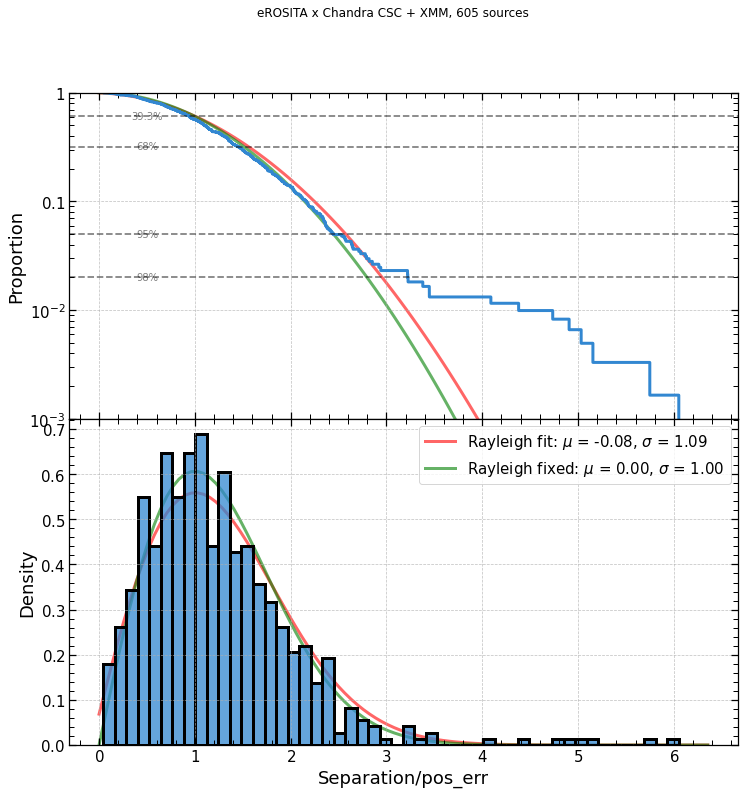

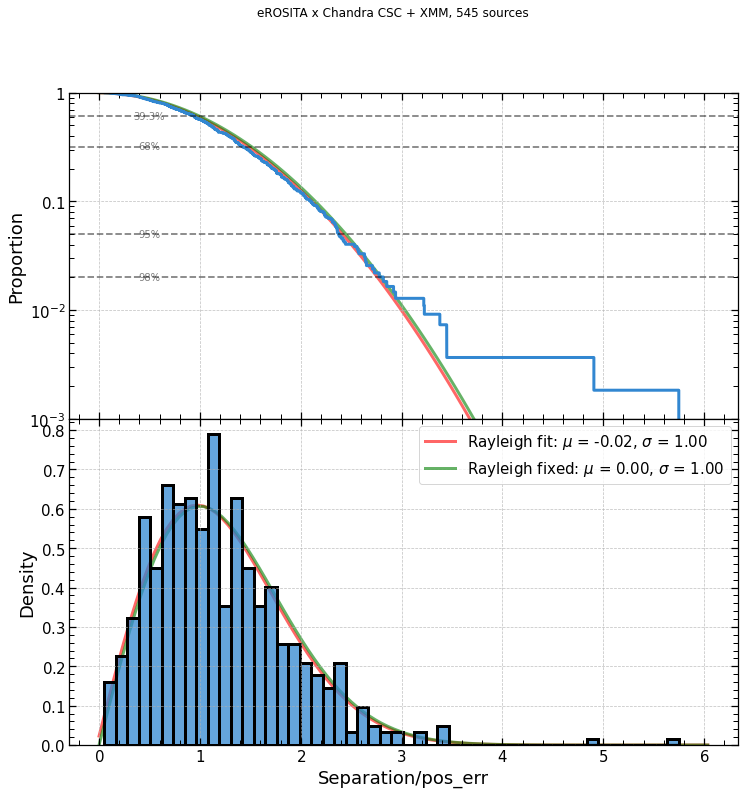

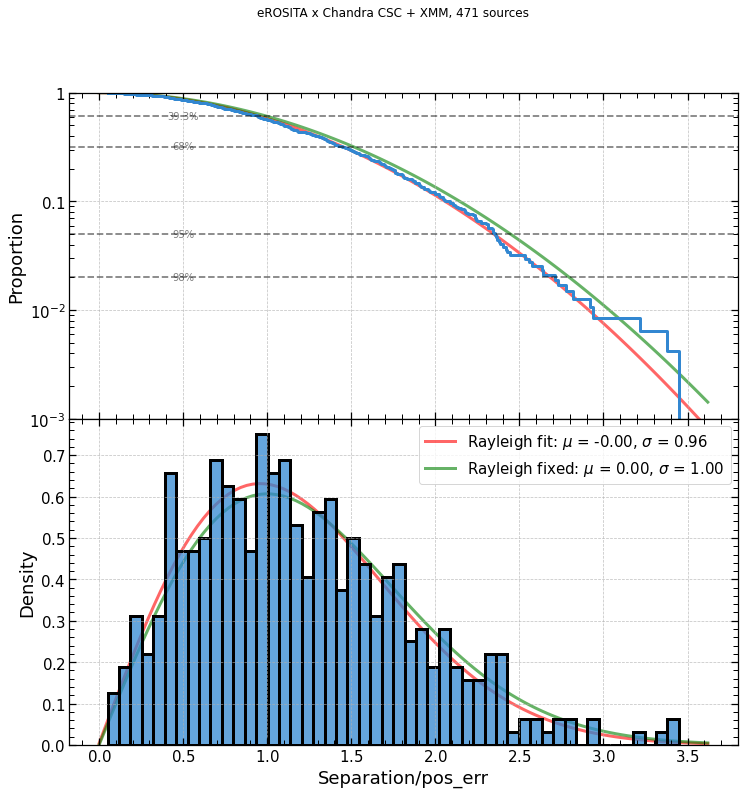

In [216]:
from scripts.cross_match_scripts import rayleigh_plot
rayleigh_plot(final_ctps, sep_col='sep_ero_desi', pos_err_col = 'pos_sigma_2d', plotlabel='eROSITA x Chandra CSC + XMM')
rayleigh_plot(final_ctps.query("DET_LIKE_0>10"), sep_col='sep_ero_desi', pos_err_col = 'pos_sigma_2d', plotlabel='eROSITA x Chandra CSC + XMM')
rayleigh_plot(final_ctps.query("DET_LIKE_0>15"), sep_col='sep_ero_desi', pos_err_col = 'pos_sigma_2d', plotlabel='eROSITA x Chandra CSC + XMM')


<AxesSubplot:xlabel='RADEC_ERR_fin', ylabel='Count'>

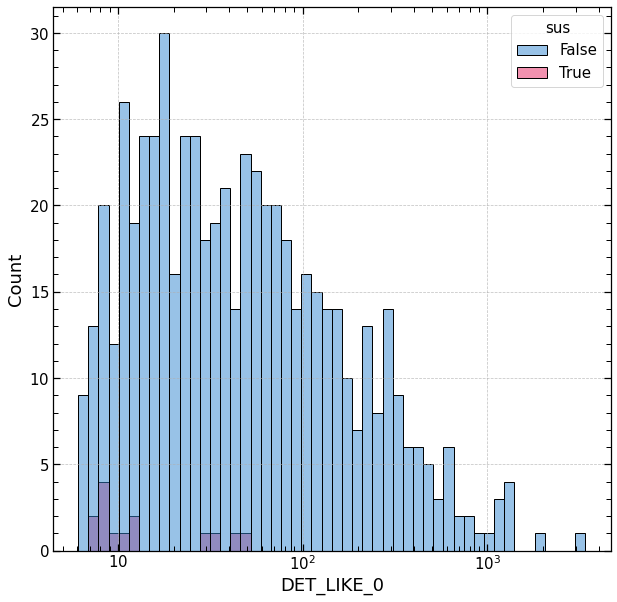

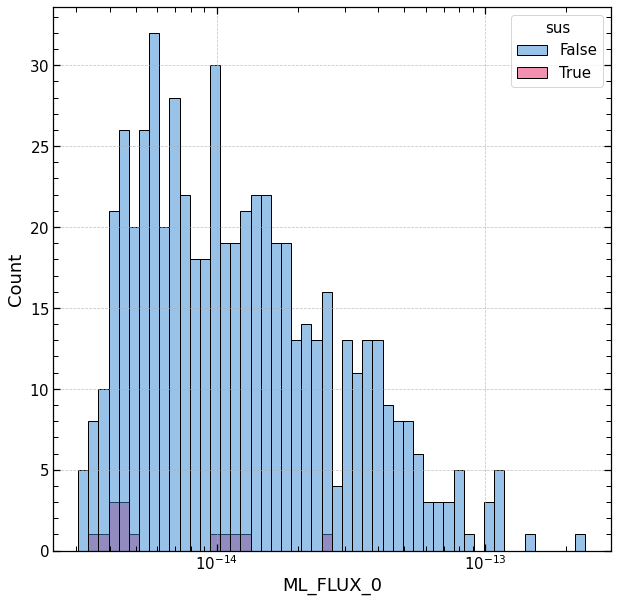

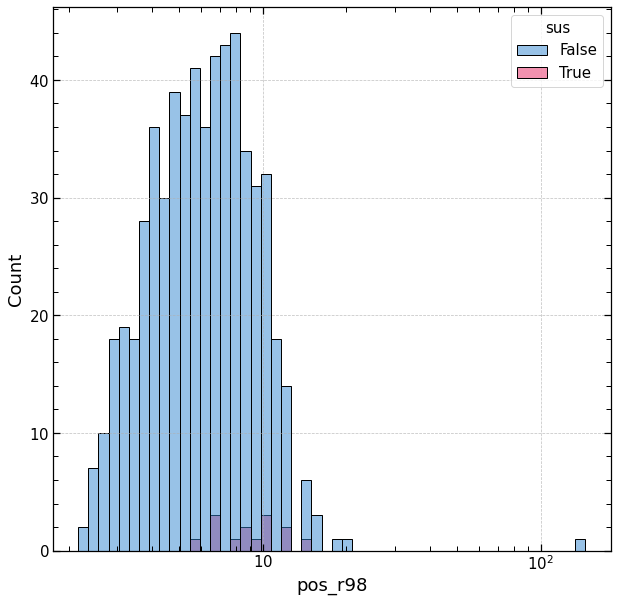

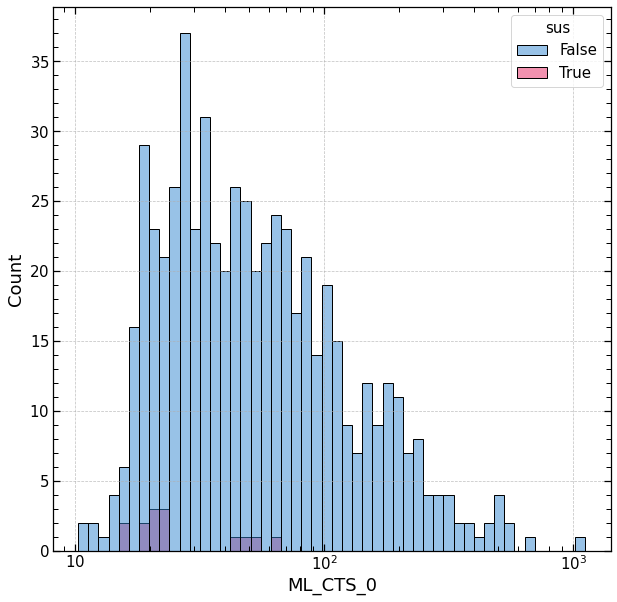

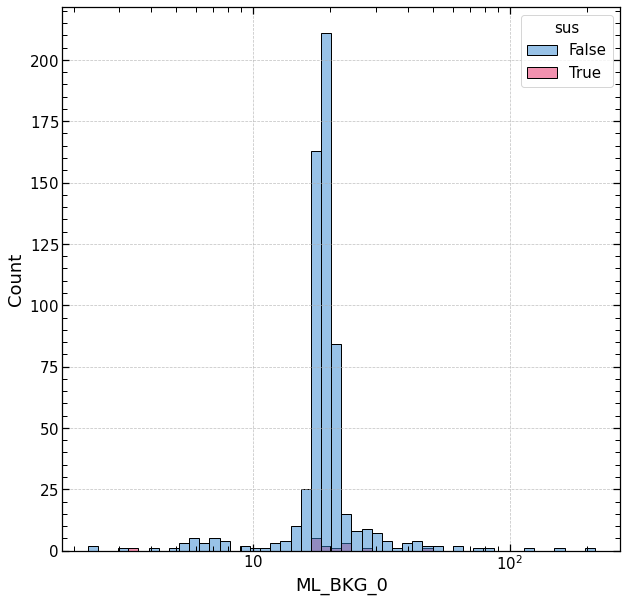

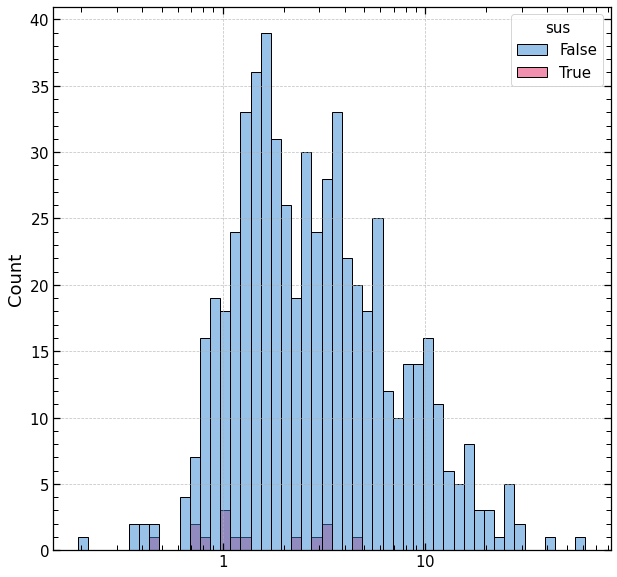

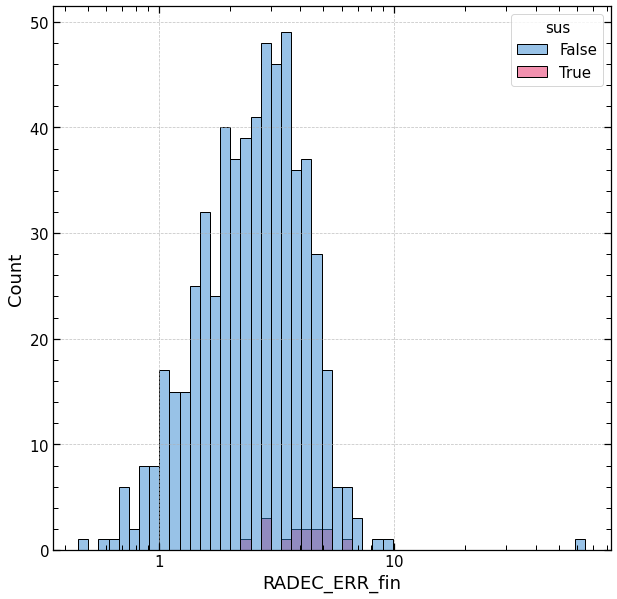

In [217]:
plt.figure(figsize=(10,10))
sns.histplot(data = final_ctps, x = 'DET_LIKE_0', hue = 'sus', log_scale=True, bins = 50)

plt.figure(figsize=(10,10))
sns.histplot(data = final_ctps, x = 'ML_FLUX_0', hue = 'sus', log_scale=True, bins = 50)


plt.figure(figsize=(10,10))
sns.histplot(data = final_ctps, x = 'pos_r98', hue = 'sus', log_scale=True, bins = 50)

plt.figure(figsize=(10,10))
sns.histplot(data = final_ctps, x = 'ML_CTS_0', hue = 'sus', log_scale=True, bins = 50)
plt.figure(figsize=(10,10))
sns.histplot(data = final_ctps, x = 'ML_BKG_0', hue = 'sus', log_scale=True, bins = 50)

plt.figure(figsize=(10,10))
sns.histplot(data = final_ctps, x = final_ctps.ML_CTS_0/final_ctps.ML_BKG_0, hue = 'sus', log_scale=True, bins = 50)

plt.figure(figsize=(10,10))
sns.histplot(data = final_ctps, x = 'RADEC_ERR_fin', hue = 'sus', log_scale=True, bins = 50)